# Project Valid Ingredients Lines.
Wellio’s recommendation system allows a user to ask for recipe through a conversational interface. When a recipe is displayed and ingredients are displayed, we have noticed that some of the ingredients are in fact preparations steps and therefore, they should be not appear as it is confusing and does not provide an optimal user experience.

## Product Use Case.
As a user I can search for recipes and when I chose one, I can see that all the ingredients required are such, and no preparation step is displayed so I’m not confused.

## Tech Use Case.
Design an algorithm that classifies a recipe ingredient as true/false, and if false, it’s not displayed.

## Data.
Data has been manually labeled using CrowdFlower and be found here:

gs://"kadaif.getwellio.com/kadaif/datasets/ingredients/labeled_lines/job_995939 2.json"

This notebook is intended to perform EDA on the labeled data.

In [1]:
reset -fs

In [2]:
import re
import json
import pprint
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import prettypandas as pretty
import datalab.bigquery as bq
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline

To be able to see all content columns of a pandas dataframe, we set the width of the columns to max.

In [3]:
pd.set_option('display.max_colwidth', -1)

Reading data from a bucket.

In [4]:
%%storage read --variable ingredients --object gs://"kadaif.getwellio.com/kadaif/datasets/ingredients/labeled_lines/job_995939 2.json"

We create a list from the json file.

In [5]:
ingredients = [json.loads(x) for x in ingredients.splitlines()]

In [6]:
len(ingredients)

14400

Check the structure of the json file from one line item.

In [7]:
pprint.pprint(ingredients[0])

{u'agreement': 0.5,
 u'created_at': u'2017-03-06T22:18:51+00:00',
 u'data': {u'entities_ingredient_entity': u'all ingredients to',
           u'entities_ingredient_entity_frequency': u'94044',
           u'lines_line': u'Add all ingredients to list',
           u'lines_url': u'http://allrecipes.com/recipe/90500/beet-salad-with-goat-cheese/'},
 u'gold_pool': None,
 u'id': 1174009206,
 u'job_id': 995939,
 u'judgments_count': 3,
 u'missed_count': 0,
 u'results': {u'a_is_a_valid_ingredient_line': {u'agg': u'no',
                                                u'confidence': 1.0},
              u'b_is_the_correct_ingredient_entity': {u'agg': None,
                                                      u'confidence': None},
              u'judgments': [{u'acknowledged_at': None,
                              u'city': u'Riyadh',
                              u'country': u'SAU',
                              u'created_at': u'2017-03-08T10:17:12+00:00',
                              u'data': {u'

In [8]:
def process_json(record):
    """
    This function will create a dictionary to store relevant data point from the json elements, which is everything under 'data'.
    After that, we will store all information under 'results', 'judgments'.
    """
    ingredient_line_info = {'ingredient_line_entity':record['data']['entities_ingredient_entity'],
              'ingredient_line_frequency': record['data']['entities_ingredient_entity_frequency'],
              'ingredient_line': record['data']['lines_line'],
              'ingredient_url': record['data']['lines_url']}  
  
    judgments = record['results']['judgments']
  
    response = []
    for judgment in judgments:
        if 'a_is_a_valid_ingredient_line' in judgment['data']:
            item_info = dict(ingredient_line_info)
        cf_data = judgment['data']
        item_info['line_item_info_valid'] = cf_data.get('a_is_a_valid_ingredient_line')
        item_info['line_item_info_other_information'] = cf_data.get('what_information_is_present_in_the_invalid_ingredient_line')
        
        response.append(item_info)
  
    return response   

We process of items from the json file.

In [9]:
results = []
for item in ingredients:
    results.extend(process_json(item))

In [10]:
results[0]

{'ingredient_line': u'Add all ingredients to list',
 'ingredient_line_entity': u'all ingredients to',
 'ingredient_line_frequency': u'94044',
 'ingredient_url': u'http://allrecipes.com/recipe/90500/beet-salad-with-goat-cheese/',
 'line_item_info_other_information': [u'other_or_none_of_the_above'],
 'line_item_info_valid': u'no'}

In [11]:
results[0]['line_item_info_other_information'][0]

u'other_or_none_of_the_above'

In [12]:
print ', '.join(results[0]['line_item_info_other_information'])

other_or_none_of_the_above


In [13]:
#for x in results[0]:
  #if x == 'line_item_info_other_information':
    #results[0]['line_item_info_other_information'] = ', '.join(results[0]['line_item_info_other_information'])
    #print results[0]['line_item_info_other_information']

One item from the dictionary is a list ('line_item_info_other_information'), so we will convert it into a string.

In [14]:
for item in results:
    if item['line_item_info_other_information']:
        item['line_item_info_other_information'] = ', '.join(item['line_item_info_other_information'])

We create a pandas dataframe from our list.

In [15]:
ingredient_data = pd.DataFrame(results)

We remove duplicates.

In [16]:
ingredient_data = ingredient_data.drop_duplicates()
pretty.PrettyPandas(ingredient_data.sort_values(['ingredient_line_entity','ingredient_line_frequency','ingredient_line']).sample(5))

In [17]:
print ingredient_data.shape

(16493, 6)


Most of the items are valid ingredient lines.

In [18]:
print ingredient_data.line_item_info_valid.value_counts()

yes    12929
no     3564 
Name: line_item_info_valid, dtype: int64


In [19]:
print((ingredient_data.line_item_info_valid.value_counts()/ingredient_data.line_item_info_valid.value_counts().sum())*100)

yes    78.390832
no     21.609168
Name: line_item_info_valid, dtype: float64


Let's see the breakdown of items that are not valid ingredients:

In [20]:
ingredient_data[ingredient_data['line_item_info_valid'] == 'no'].line_item_info_other_information.value_counts()

section_header                                                   1563
other_or_none_of_the_above                                       1500
cooking_equipment                                                358 
section_header, other_or_none_of_the_above                       89  
cooking_equipment, section_header, other_or_none_of_the_above    31  
cooking_equipment, other_or_none_of_the_above                    16  
cooking_equipment, section_header                                7   
Name: line_item_info_other_information, dtype: int64

In [21]:
ingredient_data_not_valid = pd.DataFrame(data=ingredient_data[ingredient_data['line_item_info_valid'] == 'no'].line_item_info_other_information.value_counts())

In [22]:
ingredient_data_not_valid = ingredient_data_not_valid.reset_index()

In [23]:
ingredient_data_not_valid.columns=['line_item_info_other_information', 'item_count']

In [24]:
ingredient_data_not_valid

,line_item_info_other_information,item_count
0,section_header,1563
1,other_or_none_of_the_above,1500
2,cooking_equipment,358
3,"section_header, other_or_none_of_the_above",89
4,"cooking_equipment, section_header, other_or_none_of_the_above",31
5,"cooking_equipment, other_or_none_of_the_above",16
6,"cooking_equipment, section_header",7


Most of the not valid ingredient lines are 'section_header' and 'other_or_none_of_the_above'.

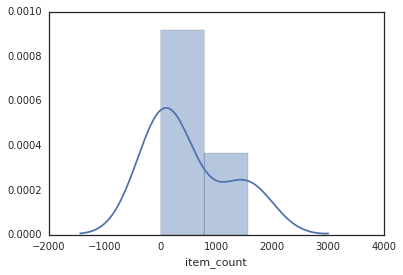

In [25]:
sns.distplot(ingredient_data_not_valid['item_count']);

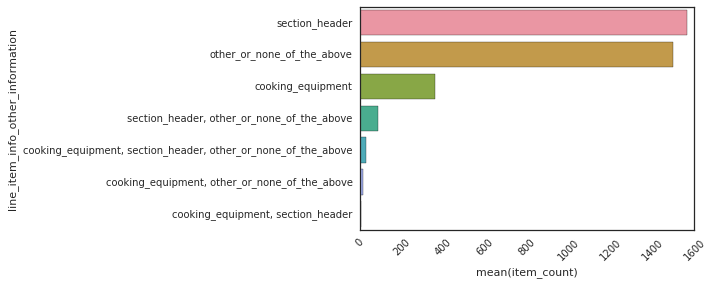

In [26]:
ingredients_plot = sns.barplot(x='item_count', y='line_item_info_other_information', data=ingredient_data_not_valid)
plt.setp(ingredients_plot.get_xticklabels(), rotation=45);